16 March 2024
# <center>Data Science Salary Analysis - CS 4315<center>
<center>Doug Andrade</center>

### Introduction<a id='intro'></a>
The original intent was to analyze motor vehicle collision data produced by the NYPD and maintained by NYC Open Data (https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data). However, after a closer look at the dataset's $2.07$ million records and $29$ features, with several categorical features missing over a million values, I realized the dataset would require significantly more time and compute power than I had available to perform a full analysis and run a machine learning algorithm.

The motor vehicle dataset would make this project unnecessarily difficult to achieve, so I pivoted to instead analyze and predict data science salaries using a appropriately sized dataset available on Kaggle (https://www.kaggle.com/datasets/henryshan/2023-data-scientists-salary?rvi=1). This data science salary dataset contained $3755$ records and $11$ features, with no missing data.

The data science analysis plan evolved to the following:
   1. [Load and preview the data](#step1)
   2. [Statistical analysis with visual plots](#step2)
   3. [Feature and Label Reduction](#step3)
   4. [Data Preprocessing Part 1: Encode the Categorical Features](#step4)
   5. [Data Preprocessing Part 2: Standardize the Data (Z-Score)](#step5)
   6. [K-Nearest Neighbors Regression Modeling](#step6)
   7. [Predict Salary on New Data Inputs](#step7)

### Modules

In [1]:
import pandas as pd                                  # For data frame operations and preprocessing
import numpy as np                                   # For mathematical operations
import matplotlib.pyplot as plt                      # Plotting of the statistic visuals

from collections import Counter                      # To count the number of unique elements in a list or string
from sklearn.model_selection import train_test_split # To prep the data for fitting and prediction evaluation
from sklearn.neighbors import KNeighborsRegressor    # Model/algorithm to be used for the salary prediction
from sklearn.metrics import r2_score                 # To evaluate model performance

[Return to Introduction](#intro)

### 1. Data Loading and Preview<a id='step1'></a>
The 2023 Data Scientist Salary dataset was found on Kaggle (https://www.kaggle.com/datasets/henryshan/2023-data-scientists-salary), courtesy of Henry Shan (https://www.kaggle.com/henryshan). 

I chose this dataset party because it had a $10.00$ usability Kaggle rating. Its number of records and features was also adequate for fast computation on my personal laptop, while still large enough to provide an interesting analysis and sensible training robustness for machine learning. Lastly, the Kaggle page hosting the dataset contained brief explanations of the dataset's features and the labels, helping to make sense of the analysis performed in this project.

In [2]:
# Load and check the dimensions of the dataset
raw_df = pd.read_csv(filepath_or_buffer = 'ds_salaries.csv')
raw_df.shape

(3755, 11)

In [3]:
# Preview the data
raw_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


[Return to Introduction](#intro)

###  2. Statistical Analysis and Plots <a id='step2'></a>

Conveniently, there is no missing data. While not representative of most real-world datasets, this did make for a more focused analysis and machine learning application.

The numeric data statistics summary informed that we can probably focus on records from $2022$ and $2023$, and use `salary_in_usd` over `salary` data (lots of outliers), since the `salary` column has extremely diverse exchange rates, making its variance and standard deviation exceptionally large and not useful.

The categorical data statistics summary highlights the large number of countries and locations represented, as well as job titles. Focusing on specific years, popular job titles, and most common countries/locations is a pragmatic approach to a focused analysis of the data.

In [4]:
# Check for missing values
raw_df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [5]:
# Review numeric feature statistics
raw_df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


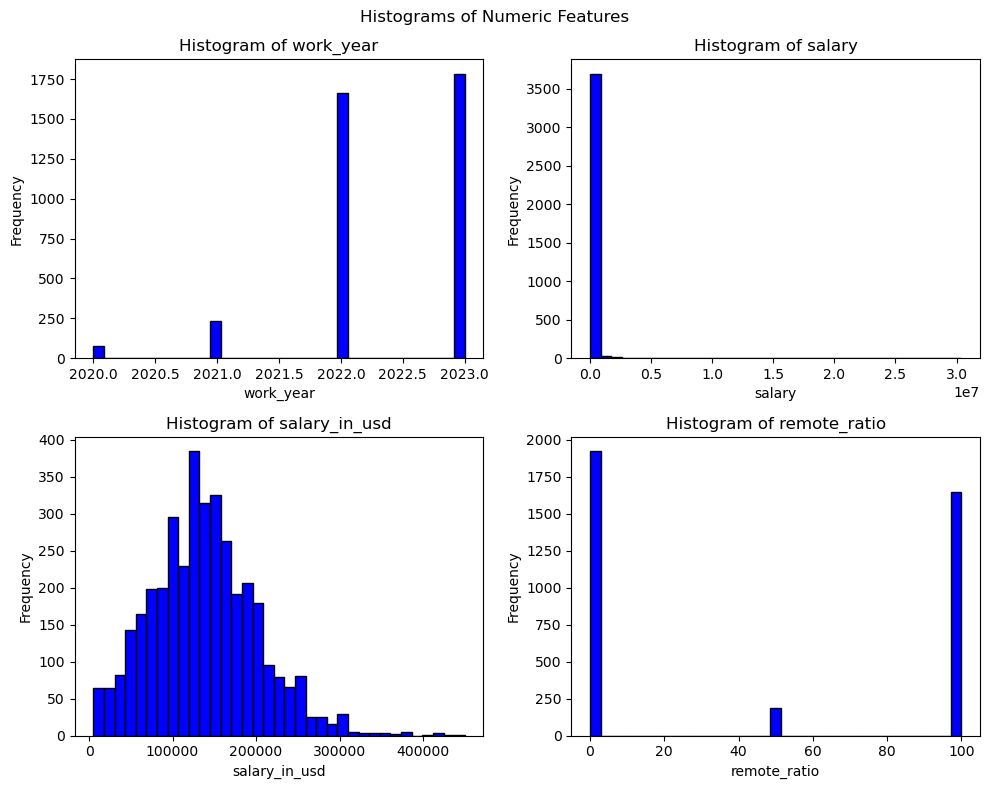

In [6]:
# Visualize the numerical feature statistics

# Use list comprehension to iterate through each feature for the numeric dtypes
numeric_col = [col for col in raw_df.columns if raw_df[col].dtype != 'object']

# Derive the number of subplots based on the number of numeric features
fig, axes = plt.subplots(nrows = len(numeric_col) // 2 + len(numeric_col) % 2, 
                         ncols = len(numeric_col) // 2 - len(numeric_col) % 2, 
                         figsize = (10, 8))

fig.suptitle('Histograms of Numeric Features')

for i, col_name in enumerate(numeric_col):
    row = i // 2 # division by 2
    col = i % 2 # modulus or remainder of division by 2 (alternate between 0 and 1)
    axes[row, col].hist(raw_df[col_name], 
                        bins = 35, 
                        color = 'blue', 
                        edgecolor = 'black')
    axes[row, col].set_title('Histogram of %s' % col_name)
    axes[row, col].set_xlabel(col_name)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout() # Prevent overlapping of plots
plt.show()

In [7]:
# Check categorical feature statistics 
raw_df.describe(include = 'object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


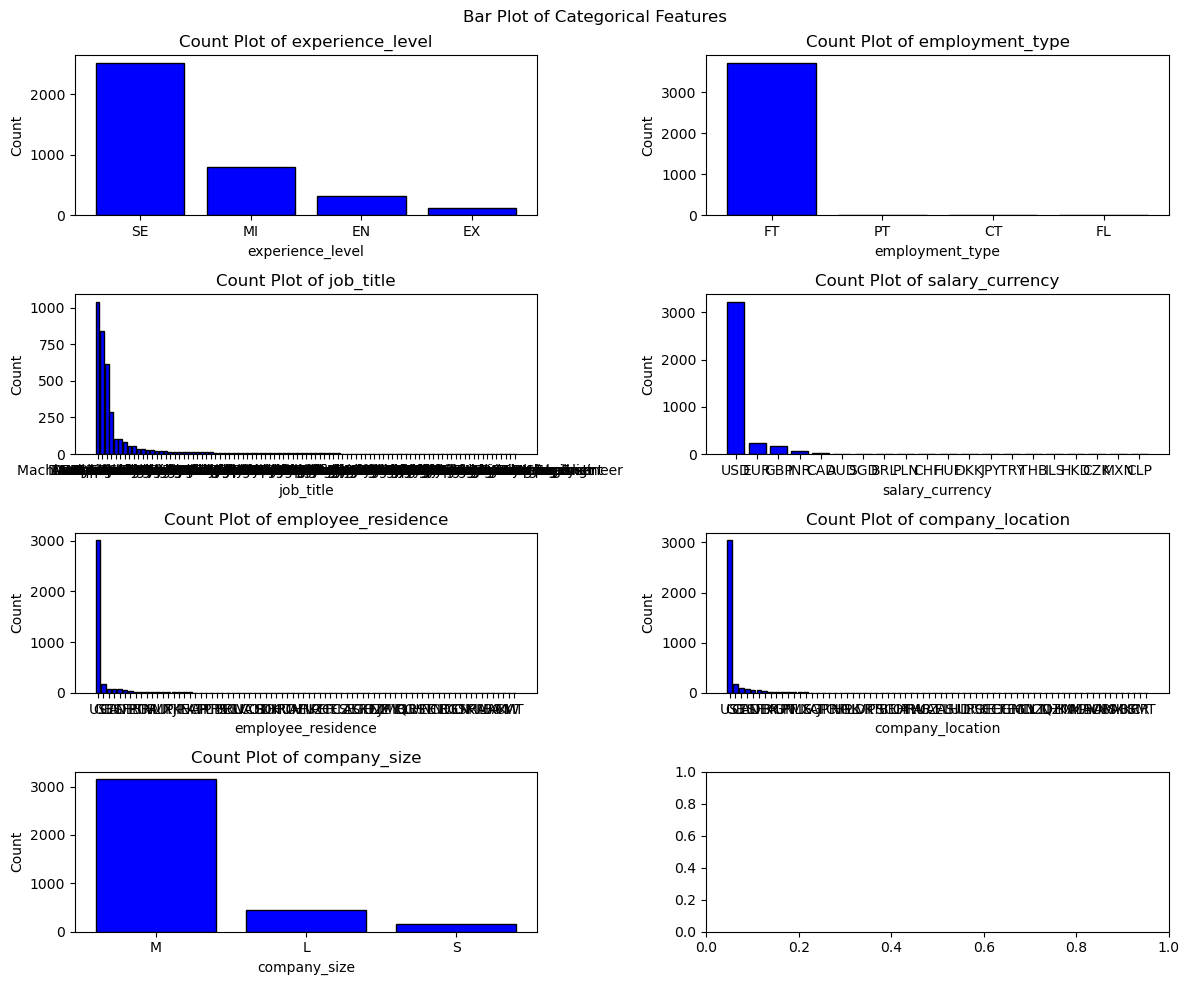

In [8]:
# Extract categorical columns from the data frame
categorical_cols = [col for col in raw_df.columns if raw_df[col].dtype == 'object']

# Create subplots based on the number of categorical columns
fig, axes = plt.subplots(nrows = len(categorical_cols) // 2 + len(categorical_cols) % 2, 
                         ncols = len(categorical_cols) // 2 - len(categorical_cols) % 2, 
                         figsize = (12, 10))
fig.suptitle('Bar Plot of Categorical Features')

# Iterate over each categorical column and create count plots
for i, col_name in enumerate(categorical_cols):
    row = i // 2
    col = i % 2

    # Get the label and associated value count of the interated feature
    value_counts = raw_df[col_name].value_counts()

    # Bar plot for each feature's label and count
    axes[row, col].bar(value_counts.index, 
                       value_counts, 
                       color = 'blue', 
                       edgecolor = 'black')
    axes[row, col].set_title('Count Plot of %s' % col_name)
    axes[row, col].set_xlabel(col_name)
    axes[row, col].set_ylabel('Count')

plt.tight_layout()
plt.show()

[Return to Introduction](#intro)

### 3. Feature and Label Reduction<a id='step3'></a>
Filters are applied to the dataset based on the statistical analysis, to reduce the number of outliers and numbers of rare labels.

In certain instances, a focused analysis on the rare labels and/or outliers would be interesting, especially if they were to be associated with extreme characteristics (high salaries, unique locations, specific company sizes, etc). However, for the purpose of the analysis, my intent is to broadly demonstrate a variety of learned analysis and machine learning techniques.

- Kept the $10$ most popular labels in `job_title` (out of $93$)
- Kept $18$ of the most common nations (out of $78$)
- Removed the `salary` and `salary_currency` columns
- Kept the `salary_in_usd` for comparable data across all records
- Removed `work_year` records of $2020$ and $2021$
- Kept `work_year` records of $2022$ and $2023$

In total I reduced the dataset size from $3755$ records and $11$ features, to a filtered dataset of $2983$ records and $9$ features.

In [9]:
# Check the feature data types to prep for standardizing
raw_df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [10]:
# Extract unique labels for each column
for col in categorical_cols:
    unique_labels = raw_df[col].unique()
    print(f"Unique labels for {col}: {unique_labels}")

Unique labels for experience_level: ['SE' 'MI' 'EN' 'EX']
Unique labels for employment_type: ['FT' 'CT' 'FL' 'PT']
Unique labels for job_title: ['Principal Data Scientist' 'ML Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Strategist' 'Data Engineer'
 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'AI Developer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'Staff Data Analyst' 'ETL Engineer' 'Data DevOps Engineer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Learning Researcher'
 'Big Data Engineer' 'Data Specialist' 'Lead Data Analyst'
 'BI Data Engineer' 'Director of Data Science'
 'Machine Learning Scientist' 'MLOps Engineer' 'AI Scientist'
 'Autonomous Vehicle Technician' 'Applied Machine Lea

In [11]:
print('Number of unique work years: %d' % len(Counter(raw_df['work_year'])))
print('Number of unique job titles: %d' % len(Counter(raw_df['job_title'])))
print('Number of unique emmployee nations: %d' % len(Counter(raw_df['employee_residence'])))
print('Number of unique company nations: %d' % len(Counter(raw_df['company_location'])))

Number of unique work years: 4
Number of unique job titles: 93
Number of unique emmployee nations: 78
Number of unique company nations: 72


In [12]:
# Extract the top 10 most common job titles
job_counts = Counter(raw_df['job_title'])
job_list = [(label) for label, count in job_counts.most_common(10)]
job_list

['Data Engineer',
 'Data Scientist',
 'Data Analyst',
 'Machine Learning Engineer',
 'Analytics Engineer',
 'Data Architect',
 'Research Scientist',
 'Applied Scientist',
 'Data Science Manager',
 'Research Engineer']

In [13]:
# Out of curiousity, check the least common job titles
job_counts.most_common()[:-11:-1]

[('Finance Data Analyst', 1),
 ('Staff Data Scientist', 1),
 ('Head of Machine Learning', 1),
 ('Cloud Data Architect', 1),
 ('Principal Data Architect', 1),
 ('Product Data Scientist', 1),
 ('Power BI Developer', 1),
 ('Data Science Tech Lead', 1),
 ('Data Management Specialist', 1),
 ('Principal Machine Learning Engineer', 1)]

In [14]:
# Count occurrences of residence and company locations
residence_counts = Counter(raw_df['employee_residence'])
comp_loc_counts = Counter(raw_df['company_location'])

# Get the top 20 labels for both residence and company locations
top_residence_labels = [label for label, count in residence_counts.most_common(20)]
top_comp_loc_labels = [label for label, count in comp_loc_counts.most_common(20)]

# Combine the common top 20 of each into a single list
country_list = list(set(top_residence_labels) & set(top_comp_loc_labels))
print(country_list)

['ES', 'FR', 'MX', 'DE', 'GB', 'NL', 'PT', 'IN', 'AT', 'JP', 'AU', 'IE', 'NG', 'GR', 'BR', 'US', 'CA', 'PL']


In [15]:
# Filter the raw dataset to keep the top 20 most common job titles
filtered_df = raw_df[raw_df['job_title'].isin(job_list)]
filtered_df = filtered_df[filtered_df['employee_residence'].isin(top_comp_loc_labels)]

# Further filter the dataset to drop the "salary" and "salary_currency" column, based on the statistics preview
filtered_df = filtered_df.drop(columns = ['salary', 'salary_currency'], axis = 1)

# Further filter the dataset to drop records for 2020 and 2021
filtered_df = filtered_df[~filtered_df['work_year'].isin([2020, 2021])]

filtered_df

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3,2023,SE,FT,Data Scientist,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,CA,100,CA,M
5,2023,SE,FT,Applied Scientist,222200,US,0,US,L
6,2023,SE,FT,Applied Scientist,136000,US,0,US,L
7,2023,SE,FT,Data Scientist,219000,CA,0,CA,M
...,...,...,...,...,...,...,...,...,...
3469,2022,MI,FT,Data Scientist,120402,CH,0,CH,L
3471,2022,MI,FT,Data Engineer,65141,FR,100,FR,M
3479,2022,MI,FL,Data Scientist,100000,CA,100,US,M
3482,2022,SE,FT,Research Scientist,144000,US,50,US,L


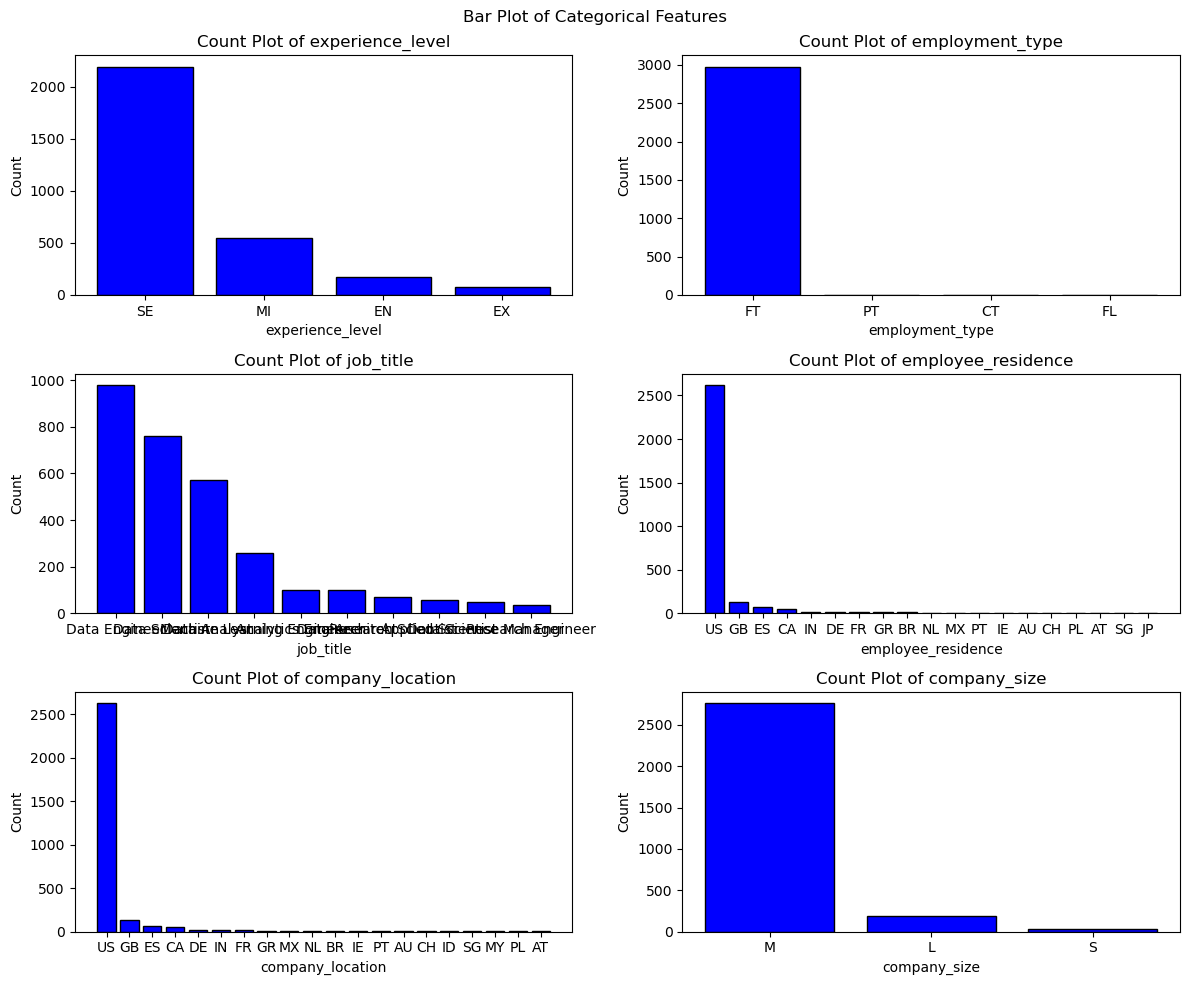

In [16]:
# Extract categorical columns from the data frame
categorical_cols = [col for col in filtered_df.columns if filtered_df[col].dtype == 'object']

# Create subplots based on the number of categorical columns
fig, axes = plt.subplots(nrows = len(categorical_cols) // 2 + len(categorical_cols) % 2, 
                         ncols = 2, 
                         figsize = (12, 10))
fig.suptitle('Bar Plot of Categorical Features')

# Iterate over each categorical column and create count plots
for i, col_name in enumerate(categorical_cols):
    row = i // 2
    col = i % 2

    # Get the label and associated value count of the interated feature
    value_counts = filtered_df[col_name].value_counts()

    # Bar plot for each feature's label and count
    axes[row, col].bar(value_counts.index, 
                       value_counts, 
                       color = 'blue', 
                       edgecolor = 'black')
    axes[row, col].set_title('Count Plot of %s' % col_name)
    axes[row, col].set_xlabel(col_name)
    axes[row, col].set_ylabel('Count')

plt.tight_layout()
plt.show()

[Return to Introduction](#intro)

### 4. Data Preprocessing Part 1: Encode the Categorical Features<a id='step4'></a>
After removing outlier and rare categorical labels and work years, the next step is to encode each categorical label as a binary numerical value. This facilitates the follow-on step of feature standardization so that no one single feature outweighs another when fitting to a machine learning algorithm.

In [17]:
# List all categorical columns from the new filtered dataset
categorical_col_list = [col for col in filtered_df.columns if filtered_df[col].dtype == 'object']

# Create a new data set for preprocessing
encoded_df = filtered_df.copy()

# Loop through categorical columns
for col in categorical_col_list:
    # Check of binary columns (two categories)
    if encoded_df[col].nunique() < 3:
        # Create the new binary column name
        binary_col_name = col + ' Binary'
        # Build out the new binary column, without replacing the original
        encoded_df[binary_col_name] = encoded_df[col].replace({'No': 0, 'Yes': 1})
    # Continue looping through all non-numeric columns with 3 or more categories
    else:
        # Concatenate encoded columns to the original data frame, set drop_first to False to prevent unintended correlations
        encoded_df = pd.concat(objs = [encoded_df, 
                                       pd.get_dummies(encoded_df[col], prefix = col, drop_first = False)], 
                               axis = 1)

encoded_df.head(3)   

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,experience_level_EN,...,company_location_MX,company_location_MY,company_location_NL,company_location_PL,company_location_PT,company_location_SG,company_location_US,company_size_L,company_size_M,company_size_S
3,2023,SE,FT,Data Scientist,175000,CA,100,CA,M,False,...,False,False,False,False,False,False,False,False,True,False
4,2023,SE,FT,Data Scientist,120000,CA,100,CA,M,False,...,False,False,False,False,False,False,False,False,True,False
5,2023,SE,FT,Applied Scientist,222200,US,0,US,L,False,...,False,False,False,False,False,False,True,True,False,False


In [18]:
# Remove the original categorical features, leaving just numeric and encoded features
encoded_df = encoded_df.drop(columns = categorical_col_list, axis = 1)

In [19]:
# Check the new data frame dimension
encoded_df.shape

(2983, 63)

[Return to Introduction](#intro)

### 5. Data Preprocessing Part 2: Standardize the Data (Z-Score)<a id='step5'></a>
To preserve the integrity of the final validation and testing of the machine learning model, the dataset standardization needs to be performed separately on a specific training set, validation set, and test set. This is to prevent data leakage from the training set into the "unseen" validation and test sets. The validation and test sets are critical to evaluate model performance and ability to effectively predict on new data (i.e., not overfit to the training data).

The method of standardizing is to use the Z-Score ($z$), using the training dataset's mean (${\mu}$) and standard deviation (${\sigma}$). This is important to maintain consistency for comparing model performance between each data set. Of note, due to hot encoding it is possible that some encoded columns contain all $0$s. To avoid division by $0$, I added a small constant, epsilon: ${\epsilon} = 1\mathrm{e}{-8}$


$$ z = \frac{x - \mu}{\sigma + \epsilon} $$

The full dataset is split $70\%$ for training, $15\%$ for validation, and $15\%$ for testing.

In [20]:
# Split the full encoded data set into train (70%), validation (15%), test sets (15%)
train, temp = train_test_split(encoded_df, test_size = 0.3, random_state = 42)
val, test = train_test_split(temp, test_size = 0.5, random_state = 42)

print('The training set shape is: %s' % (str(train.shape)))
print('The validation set shape is: %s' % (str(val.shape)))
print('The test set shape is: %s' % (str(test.shape)))

The training set shape is: (2088, 63)
The validation set shape is: (447, 63)
The test set shape is: (448, 63)


In [21]:
# To factor for columns with all 0's, I add a small constant, epsilon, to prevent division by 0
epsilon = 1e-8

# Standardize (Z-Score) the the training set
train_z = (train[train.columns[:]] - train[train.columns[:]].mean(axis = 0)) / (train[train.columns[:]].std(axis = 0) + epsilon)
X_train_z = train_z.drop(columns = 'salary_in_usd', axis = 1)
X_train_z.head(3)


,work_year,remote_ratio,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,...,company_location_MX,company_location_MY,company_location_NL,company_location_PL,company_location_PT,company_location_SG,company_location_US,company_size_L,company_size_M,company_size_S
3118,-1.037832,1.133094,4.179654,-0.174893,-0.482156,-1.633498,0.0,-0.021884,0.0438,-0.037923,...,-0.048982,-0.021884,-0.048982,0.0,-0.05367,0.0,0.367879,3.895994,-3.606548,-0.098319
279,0.963085,1.133094,-0.239140,-0.174893,-0.482156,0.611890,0.0,-0.021884,0.0438,-0.037923,...,-0.048982,-0.021884,-0.048982,0.0,-0.05367,0.0,0.367879,-0.256551,0.277141,-0.098319
1800,0.963085,1.133094,-0.239140,-0.174893,2.073025,-1.633498,0.0,-0.021884,0.0438,-0.037923,...,-0.048982,-0.021884,-0.048982,0.0,-0.05367,0.0,-2.716984,-0.256551,0.277141,-0.098319


In [22]:
# Standardize (Z-Score) the validation set, using the training mean and standard deviation
val_z = (val[train.columns[:]] - train[train.columns[:]].mean(axis = 0)) / (train[train.columns[:]].std(axis = 0) + epsilon)
X_val_z = val_z.drop(columns = 'salary_in_usd', axis = 1)
X_val_z.head(3)

,work_year,remote_ratio,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,...,company_location_MX,company_location_MY,company_location_NL,company_location_PL,company_location_PT,company_location_SG,company_location_US,company_size_L,company_size_M,company_size_S
1379,0.963085,-0.890773,-0.23914,-0.174893,-0.482156,0.61189,0.0,-0.021884,0.0438,-0.037923,...,-0.048982,-0.021884,-0.048982,0.0,-0.05367,0.0,0.367879,-0.256551,0.277141,-0.098319
1261,0.963085,-0.890773,-0.23914,-0.174893,-0.482156,0.61189,0.0,-0.021884,0.0438,-0.037923,...,-0.048982,-0.021884,-0.048982,0.0,-0.05367,0.0,0.367879,-0.256551,0.277141,-0.098319
2769,-1.037832,1.133094,-0.23914,-0.174893,-0.482156,0.61189,0.0,-0.021884,0.0438,-0.037923,...,-0.048982,-0.021884,-0.048982,0.0,-0.05367,0.0,0.367879,-0.256551,0.277141,-0.098319


In [23]:
# Standardize (Z-Score) the test set, using the training mean and standard deviation
test_z = (test[train.columns[:]] - train[train.columns[:]].mean(axis = 0)) / (train[train.columns[:]].std(axis = 0) + epsilon)
X_test_z = test_z.drop(columns = 'salary_in_usd', axis = 1)
X_test_z.head(3)

,work_year,remote_ratio,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,...,company_location_MX,company_location_MY,company_location_NL,company_location_PL,company_location_PT,company_location_SG,company_location_US,company_size_L,company_size_M,company_size_S
233,0.963085,-0.890773,-0.23914,-0.174893,-0.482156,0.611890,0.0,-0.021884,0.0438,-0.037923,...,-0.048982,-0.021884,-0.048982,0.0,-0.05367,0.0,0.367879,-0.256551,0.277141,-0.098319
922,0.963085,-0.890773,-0.23914,-0.174893,-0.482156,0.611890,0.0,-0.021884,0.0438,-0.037923,...,-0.048982,-0.021884,-0.048982,0.0,-0.05367,0.0,0.367879,-0.256551,0.277141,-0.098319
2093,-1.037832,1.133094,-0.23914,-0.174893,2.073025,-1.633498,0.0,-0.021884,0.0438,-0.037923,...,-0.048982,-0.021884,-0.048982,0.0,-0.05367,0.0,-2.716984,-0.256551,0.277141,-0.098319


[Return to Introduction](#intro)

### 6. K-Nearest Neighbors Regression Modeling and Evaluation<a id='step6'></a>
The intent is to predict salary based on job title, location, company size, etc. Therefore, the appropriate model to apply (from the group of machine learning algorithms learned in the course) is the KNN Regression model. This model uses Euclidean distances, averaged between all $k$-sized "neighborhoods" of similar data across all the predictor features, to map to the most likely salary value. 

Since the prediction is a continuous value, the best method to evaluate model performance is R Squared ($r^2$), which provides a measure between $0$ and $1$ of how well the variance in the target variable, `salary`, is explained by the features. An $r^2 = 0$ indicates no variance is explained and therefore the model is essentially assigning random salary values. An $r^2 = 1$ indicates that $100\%$ of the feature variability is explained by the model's predicted target variable.

To select the optimal value of $k$ (number of neighbors), we iterate over a range of $1 - 20$ for the `n_neighbors` parameter, all the while calculating the $r^2$ for each data set. The highest average $r^2$ value across all sets is chosen as the optimal $k$ value for the final KNN Regression model. This model is then used to predict salaries for data science jobs.

In [24]:
# Define a range of n_neighbors values to iterate over
n_neighbors_range = range(1, 21)

# Create an empty list to store the DataFrames for each iteration
metrics_df = []

for n_neighbors in n_neighbors_range:
    # Create and fit the model with the current n_neighbors value
    knn_regressor = KNeighborsRegressor(n_neighbors = n_neighbors, weights = 'uniform', metric = 'euclidean')
    knn_regressor.fit(X_train_z, train['salary_in_usd'])

    # Predict on each data set
    train_prediction = knn_regressor.predict(X_train_z)
    val_prediction = knn_regressor.predict(X_val_z)
    test_prediction = knn_regressor.predict(X_test_z)

    # Evaluate the model
    train_r2 = r2_score(train['salary_in_usd'], train_prediction)
    val_r2 = r2_score(val['salary_in_usd'], val_prediction)
    test_r2 = r2_score(test['salary_in_usd'], test_prediction)

    # Create a DataFrame for the current iteration
    iteration_row = pd.DataFrame({
        'n_neighbors': [n_neighbors],
        'Train R2': [train_r2],
        'Validation R2': [val_r2],
        'Test R2': [test_r2]
    })

    # Append the current iteration_row to the metris_df list
    metrics_df.append(iteration_row)

# Concatenate metrics_df list to create the final results data frame
metrics_df = pd.concat(metrics_df, ignore_index = True)

# Print the results table
metrics_df

,n_neighbors,Train R2,Validation R2,Test R2
0,1,-0.322873,-0.313034,-0.380336
1,2,0.154472,0.119546,0.036173
2,3,0.202330,0.137830,0.033315
3,4,0.295602,0.241033,0.160680
4,5,0.312630,0.264138,0.176998
5,6,0.321454,0.265485,0.186007
6,7,0.336854,0.289634,0.217521
7,8,0.343188,0.306989,0.229104
8,9,0.352899,0.318319,0.244231
9,10,0.349692,0.329003,0.249006


In [25]:
# Extract the highest average R Squared n_neighbors iteration
k = metrics_df[['Train R2', 'Validation R2', 'Test R2']].mean(axis = 1).idxmax() + 1
print('The optimal n_neighbors is: %d' % k)

The optimal n_neighbors is: 12


In [26]:
# Set the number of k-nearest neighbors, uniformly weighted, using the Euclidean distance metric
knn_regressor_euclidean = KNeighborsRegressor(n_neighbors = k,
                                              weights = 'uniform', 
                                              metric = 'euclidean')

# Fit the model on the Z-Score training set features to be learned on their associated and original salary target values
knn_regressor_euclidean.fit(X_train_z, train['salary_in_usd'])

KNeighborsRegressor(metric='euclidean', n_neighbors=12)

[Return to Introduction](#intro)

### 7. Predict Salary on a Single Test set Inputs<a id='step7'></a>
Overall, the $r^2$ values were not impressive, and would suggest a different machine learning approach. Most of the predictor values were heavily skewed, potentially introducing significant bias. Additional feature engineering to normalize the data could be beneficial, but beyond the scope of this project.

When testing the KNN model on a single test record, it's apparent this model wouldn't be a reliable way to predict a salary based on job title, location, company title and percent remote. Beware, it tends to be overly optimistic!

In [27]:
# Randomly select a test set record
rand_test_idx = np.random.randint(0, len(test))
test_sample = test.iloc[rand_test_idx]
test_pred = knn_regressor.predict(X_test_z.iloc[rand_test_idx].values.reshape(1, -1))

/home/drandrade/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [28]:
print('The predictor values for the job salary:\n')
for i, value in enumerate(test_sample):
    if value == 1:
        print(i, test_sample.index[i])

The predictor values for the job salary:

6 experience_level_SE
9 employment_type_FT
12 job_title_Applied Scientist
39 employee_residence_US
59 company_location_US
60 company_size_L


In [29]:
print('The predicted salary is  : $%d' % (test_pred))
print('The actual salary is     : $%d' % (test.iloc[rand_test_idx]['salary_in_usd']))
print('\nThe prediction was off by: $%d' % (abs(test.iloc[rand_test_idx]['salary_in_usd'] - test_pred)))

The predicted salary is  : $185954
The actual salary is     : $159100

The prediction was off by: $26854
